In [3]:
import sys
import platform
old_stderr = sys.stderr
sys.stderr = open('/dev/null' if platform.system() != 'Windows' else 'nul', 'w')

sys.stderr = old_stderr

import random
from scipy.ndimage import affine_transform

import pickle
import numpy as np
from math import sqrt

# Determise the size of each image
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook

from pandas import read_csv
import pandas as pd
from pathlib import Path
from utils import *

In [5]:
root_dir = Path('../input')
train_dir = root_dir/'train'
annot_dir = root_dir/'annotation'

In [34]:
SZ = 224

In [7]:
annotations = json.load(open(annot_dir/'annotations.json'))

In [8]:
len(annotations)

400

In [73]:
annotations[0]

{'annotations': [{'class': 'fluke',
   'height': 372.0,
   'type': 'rect',
   'width': 1017.0,
   'x': 14.0,
   'y': 97.0},
  {'class': 'left',
   'type': 'point',
   'x': 50.802273527488566,
   'y': 98.58659021176},
  {'class': 'notch',
   'type': 'point',
   'x': 516.2391276137811,
   'y': 269.48861474128864},
  {'class': 'right',
   'type': 'point',
   'x': 1013.5305065138045,
   'y': 102.10753986218477}],
 'class': 'image',
 'filename': '6138dce83.jpg'}

In [85]:
anno = annotations[0]['annotations']

In [87]:
anno[1]

{'class': 'left',
 'type': 'point',
 'x': 50.802273527488566,
 'y': 98.58659021176}

In [76]:
img = open_image(train_dir/annotations[0]['filename'])

In [90]:
left_point = ImagePoints(FlowField(img.size, torch.tensor([anno[1]['y'], anno[1]['x']])), scale=True)

In [102]:
point_array = torch.tensor([[anno[1]['y'], anno[1]['x']], 
                            #[anno[2]['y'], anno[2]['x']],
                            [-1, -1],
                            [anno[3]['y'], anno[3]['x']]])

In [103]:
points = ImagePoints(FlowField(img.size, point_array))

In [165]:
def get_key_point(img_file, annotation):
    img = open_image(img_file)
    
    #get bounding box
    bbox = [-1, -1, -1, -1]
    exist = False
    for item in annotation:
        if 'class' not in item or item['class'] != 'fluke':
            continue
    if exist:
        im_height, im_width = img.size
        bb_x, bb_y, bb_width, bb_height = item['x'], item['y'], item['width'], item['height']
        top = np.clip(bb_y, 0, im_height)
        left = np.clip(bb_x, 0, im_width)
        bottom = np.clip(bb_y + bb_height, 0, im_height)
        right = np.clip(bb_x + bb_width, 0, im_width)
        bbox = ImageBBox.create(im_height, im_width, [[top,left, bottom, right]])
    
    #get key points
    key_point_list = []
    for cls_name in ['left', 'notch', 'right']:
        exist = False
        for item in annotation:
            #print(item)
            if 'class' not in item or item['class'] != cls_name:
                continue
            else:
                exist = True
                break
        if exist:
            axis = [item['y'], item['x']]
        else:
            axis= [-1, -1]
        key_point_list.append(axis)
    key_points = ImagePoints(FlowField(img.size, torch.tensor(key_point_list)))
    return bbox, key_points
        

In [166]:
bbox, kp0 = get_key_point(train_dir/annotations[0]['filename'], annotations[0]['annotations'])

In [169]:
bbox, kp0

([-1, -1, -1, -1], ImagePoints (600, 1050))

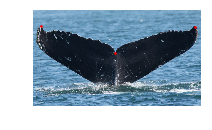

In [126]:
img.show(y=kp0)

In [77]:
im_height, im_width = img.size
bb_x, bb_y, bb_width, bb_height = anno['x'], anno['y'], anno['width'], anno['height']

In [78]:
bb_x, bb_y, bb_width, bb_height, im_width, im_height

(14.0, 97.0, 1017.0, 372.0, 1050, 600)

In [79]:
bb_x + bb_width

1031.0

In [80]:
top = np.clip(bb_y, 0, im_height)
left = np.clip(bb_x, 0, im_width)
bottom = np.clip(bb_y + bb_height, 0, im_height)
right = np.clip(bb_x + bb_width, 0, im_width)

In [81]:
top, left, bottom, right

(97.0, 14.0, 469.0, 1031.0)

In [82]:
bbox = ImageBBox.create(im_height, im_width, [[top,left, bottom, right]])

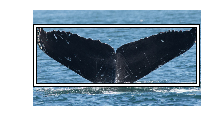

In [83]:
img.show(y=bbox)

In [ ]:
def get_annotation(image_file, anno_file):
    

In [67]:
top = np.clip(bb_y, 0, im_height) / im_height * SZ
left = np.clip(bb_x, 0, im_width) / im_width * SZ
bottom = np.clip(bb_y + bb_height, 0, im_height) / im_height * SZ
right = np.clip(bb_x + bb_width, 0, im_width) / im_width * SZ

In [68]:
top, left, bottom, right

(36.21333333333333, 2.986666666666667, 175.09333333333333, 219.9466666666667)

In [69]:
bbox = ImageBBox.create(im_height, im_width, [[top,left, bottom, right]])

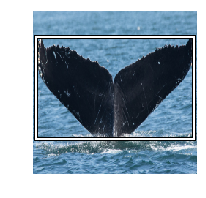

In [70]:
img.resize(SZ).show(y=bbox)

TypeError: cannot unpack non-iterable ImagePoints object

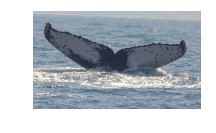

In [160]:
idx = 100
img = open_image(train_dir/annotations[idx]['filename'])
img.show()


In [164]:
#bbox, kp = get_key_point(train_dir/annotations[idx]['filename'], annotations[idx]['annotations'])
bbox, kp0 = get_key_point(train_dir/annotations[0]['filename'], annotations[0]['annotations'])
#annotations[idx]['annotations'][-1]

TypeError: cannot unpack non-iterable ImagePoints object

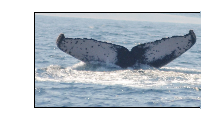

In [163]:
trans = get_transforms()[0]
bbox.apply_tfms(trans)
img.apply_tfms(trans).show(y=bbox)

In [137]:
get_transforms()

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1)}, p=1.0, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (flip_affine), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'scale': (1.0, 1.1)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is

In [140]:
bbox.data

tensor([[-0.6767, -0.9733,  0.5633,  0.9638]])

In [141]:
bbox.rotate(20).data

tensor([[-1., -1.,  1.,  1.]])